In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader

from dataloader.graph_ts_reader import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model_loss_train import *
from model.final_model import PatientOutcomeModel
from model.autoencoder_v2 import  PatientAutoencoder

import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.synchronize()

from torch.amp import GradScaler, autocast
scaler = GradScaler() 


In [12]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses_level.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === looad Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)

train_loader = DataLoader(dataset_train , batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset_val , batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(dataset_test , batch_size=16, shuffle=False, collate_fn=collate_fn)



Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [13]:
save_path = '/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth'
history_path = '/home/mei/nas/docker/thesis/data/model_results/final_model/history.json'

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained = PatientAutoencoder( n_features=154, embedding_dim=128,  n_heads=2, som_grid=(12,12)).to(device)
pretrained.load_state_dict(torch.load("/home/mei/nas/docker/thesis/data/model_results/autoencoder_v2/stage3/best_model.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
for param in model.som_layer.parameters():
    param.requires_grad = False  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [5]:
path= '/home/mei/nas/docker/thesis/data/model_results/final_model/'
model1, history = tune_ts_encoder_and_som(
    model, train_loader, val_loader, device, optimizer,
    epochs=10, patience=10, save_path=path,
    lambda_usage=0.1, lambda_entropy=0.1
)

[Tune] Fine-tuning TS Encoder + SOM with risk regression + usage/entropy loss
[Epoch 5] Train Loss: 3.4730, Val Loss: 3.4604
[Epoch 10] Train Loss: 3.4724, Val Loss: 3.4604


In [ ]:
path= '/home/mei/nas/docker/thesis/data/model_results/final_model/encoder_som_finetuned.pth'
model1 = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
model1.load_state_dict(torch.load(path,weights_only=True ))

som_weights = {
    'kl':       0.1,   # 保持 q 分布不过于集中
    'diversity':0.3,   # 保证节点之间的相互区分度
    'smooth':   0.5,   # 时间平滑约束，让相邻时间步不至于跳得太远
    'neighbor': 0.2,   # 惩罚跳跃格子过远
    'risk_cls': 1.0,   # SOM 分类和风险预测损失处于同一量级
    'align':    0.2,   # 对齐损失：让 SOM 距离和风险距离保持一致
    'usage':    0.1,   # Usage 约束：打开长期不活跃节点
}

model2,history = train_patient_outcome_model(model1, train_loader, val_loader,optimizer, device, n_epochs=40, save_path=save_path, history_path=history_path,patience=20,use_som=True,som_weights=som_weights)

Epoch 10: Train 2.8006, Val 2.7868
Epoch 20: Train 2.7575, Val 2.7562
Epoch 30: Train 2.7357, Val 2.7439
Epoch 40: Train 2.7396, Val 2.7364


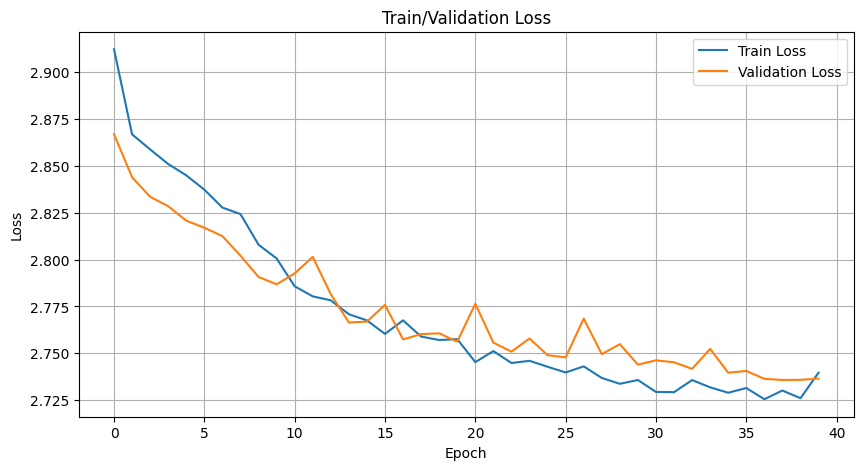

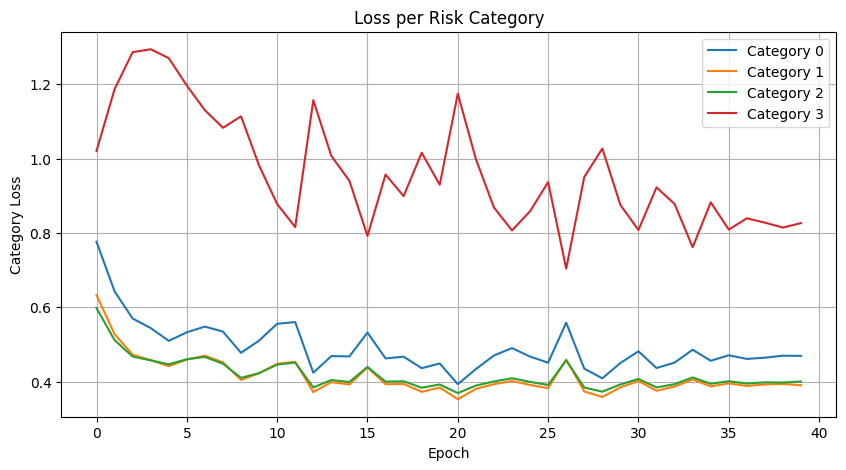

In [5]:
plot_training_history(history)

In [4]:

best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))
som_weights = {
    'kl':       0.1,   # 保持 q 分布不过于集中
    'diversity':0.3,   # 保证节点之间的相互区分度
    'smooth':   0.5,   # 时间平滑约束，让相邻时间步不至于跳得太远
    'neighbor': 0.2,   # 惩罚跳跃格子过远
    'risk_cls': 1.0,   # SOM 分类和风险预测损失处于同一量级
    'align':    0.2,   # 对齐损失：让 SOM 距离和风险距离保持一致
    'usage':    0.1,   # Usage 约束：打开长期不活跃节点
}
result = evaluate_model_on_test_set(model, test_loader, device,use_som=True,som_weights=som_weights)

[Test] Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.17it/s]


[Test] Evaluation Summary:
  Overall Test Loss: 2.6956
  Risk Category 0: Mean Loss = 0.4392, Count = 27
  Risk Category 1: Mean Loss = 0.3751, Count = 294
  Risk Category 2: Mean Loss = 0.3892, Count = 89
  Risk Category 3: Mean Loss = 0.8992, Count = 51


In [4]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

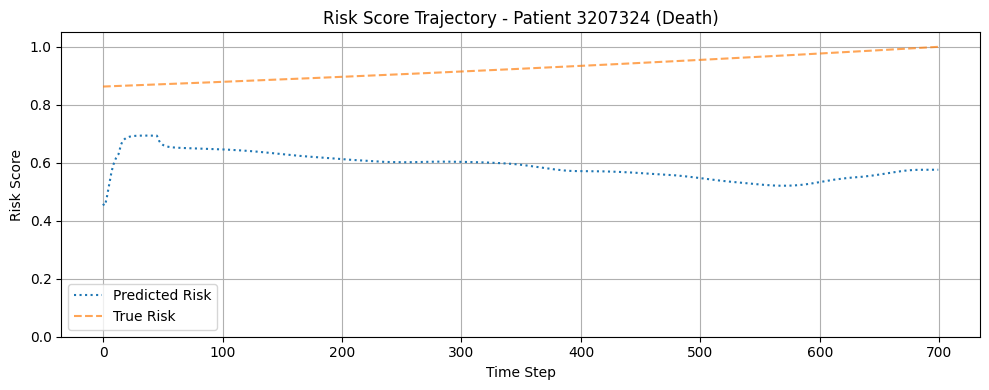

In [6]:
plot_patient_risk_trajectory(model, test_loader, patient_index=400, device=device)

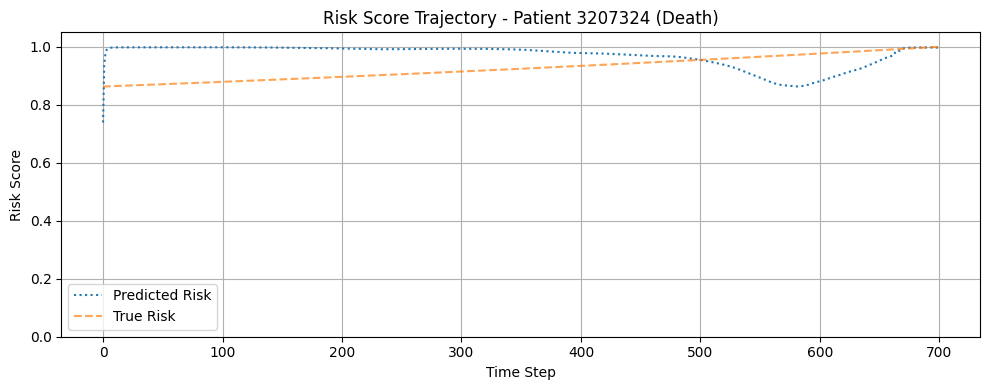

In [ ]:
plot_patient_risk_trajectory(model, test_loader, patient_index=400, device=device)

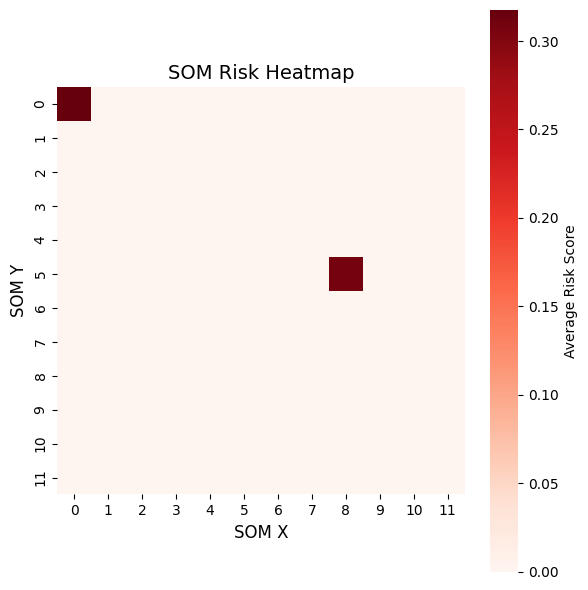

In [ ]:
k_list, risk_list = collect_k_and_risk_from_model(
    model=model,
    loader=test_loader,
    device=device,
    som_grid=(12, 12)
)
plot_som_risk_heatmap(k_list, risk_list, som_grid=(12, 12), title="SOM Risk Heatmap")
#  log 查看一下

## train model without som updation

In [16]:
path= '/home/mei/nas/docker/thesis/data/model_results/final_model/encoder_som_finetuned.pth'
model1 = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
model1.load_state_dict(torch.load(path,weights_only=True ))


save_path_no_som = '/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth'
history_path_no_som = '/home/mei/nas/docker/thesis/data/model_results/final_model/history.json'

model2,history = train_patient_outcome_model(model1, train_loader, val_loader,optimizer, device, n_epochs=40, save_path=save_path_no_som, history_path=history_path_no_som,patience=20)

Epoch 10: Train 0.4276, Val 0.4722
Epoch 20: Train 0.3488, Val 0.3763
Epoch 30: Train 0.3291, Val 0.3642
Epoch 40: Train 0.3054, Val 0.3654


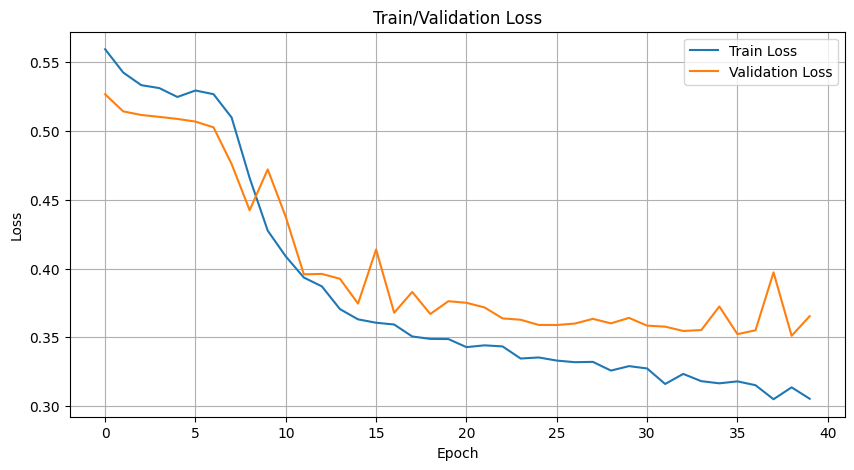

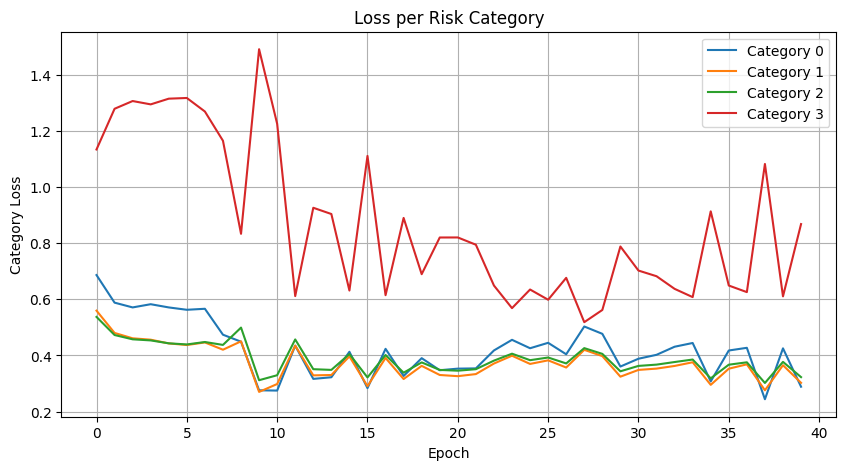

In [26]:
plot_training_history(history)

In [17]:

# best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth'
# model.load_state_dict(torch.load(best_model,weights_only=True))

result = evaluate_model_on_test_set(model2, test_loader, device)

[Test] Evaluating: 100%|██████████| 29/29 [00:03<00:00,  8.50it/s]


[Test] Evaluation Summary:
  Overall Test Loss: 0.3338
  Risk Category 0: Mean Loss = 0.2468, Count = 27
  Risk Category 1: Mean Loss = 0.2638, Count = 294
  Risk Category 2: Mean Loss = 0.3226, Count = 89
  Risk Category 3: Mean Loss = 0.9546, Count = 51


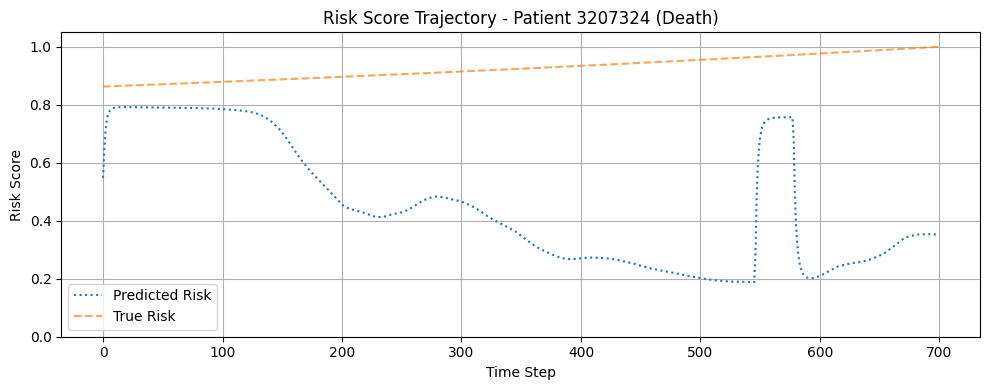

In [23]:
plot_patient_risk_trajectory(model2, test_loader, patient_index=400, device=device)

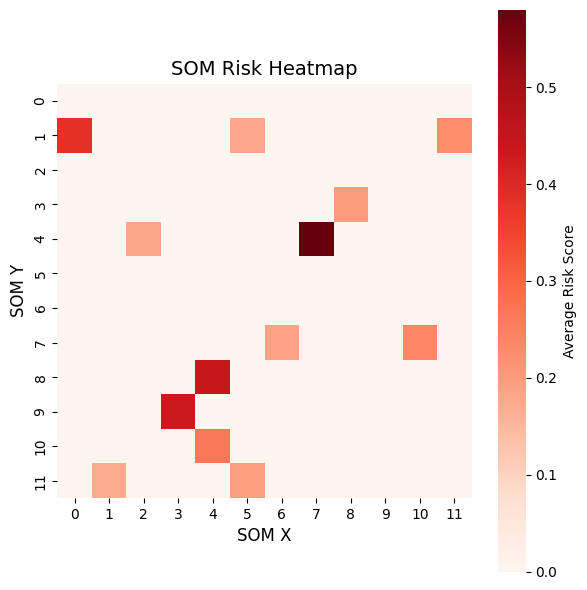

In [ ]:
k_list, risk_list = collect_k_and_risk_from_model(
    model=model2,
    loader=train_loader,
    device=device,
    som_grid=(12, 12)
)
plot_som_risk_heatmap(k_list, risk_list, som_grid=(12, 12), title="SOM Risk Heatmap")

## log
## 轨迹图 尽快可视化

#####

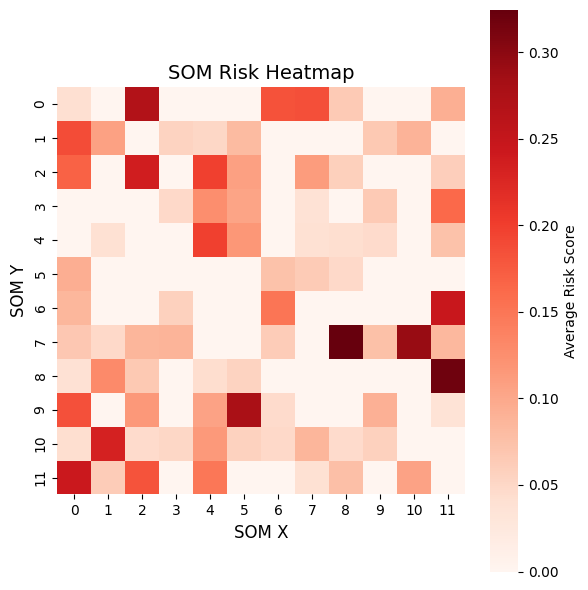

In [ ]:
k_list, risk_list = collect_k_and_risk_from_model(
    model=model,
    loader=train_loader,
    device=device,
    som_grid=(12, 12)
)
plot_som_risk_heatmap(k_list, risk_list, som_grid=(12, 12), title="SOM Risk Heatmap")

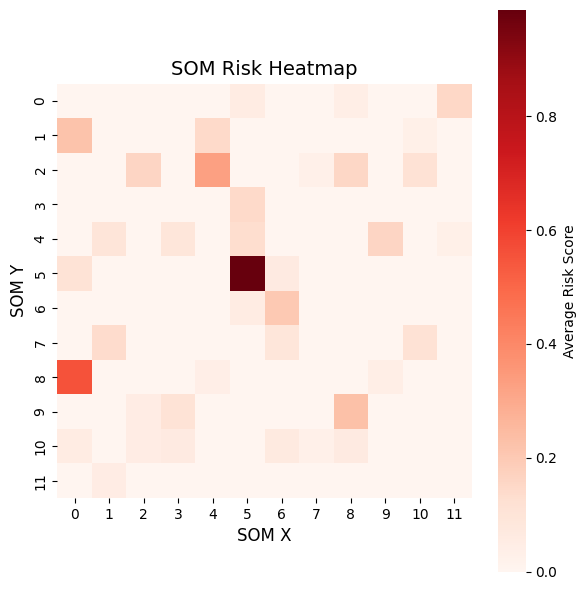

In [ ]:
k_list, risk_list = collect_k_and_risk_from_model(
    model=model,
    loader=val_loader,
    device=device,
    som_grid=(12, 12)
)

plot_som_risk_heatmap(k_list, risk_list, som_grid=(12, 12), title="SOM Risk Heatmap")

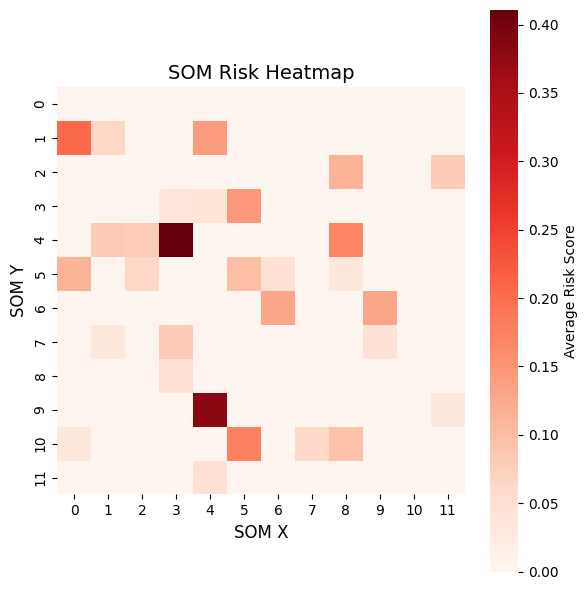

In [ ]:
k_list, risk_list = collect_k_and_risk_from_model(
    model=model,
    loader=test_loader,
    device=device,
    som_grid=(12, 12)
)

plot_som_risk_heatmap(k_list, risk_list, som_grid=(12, 12), title="SOM Risk Heatmap")


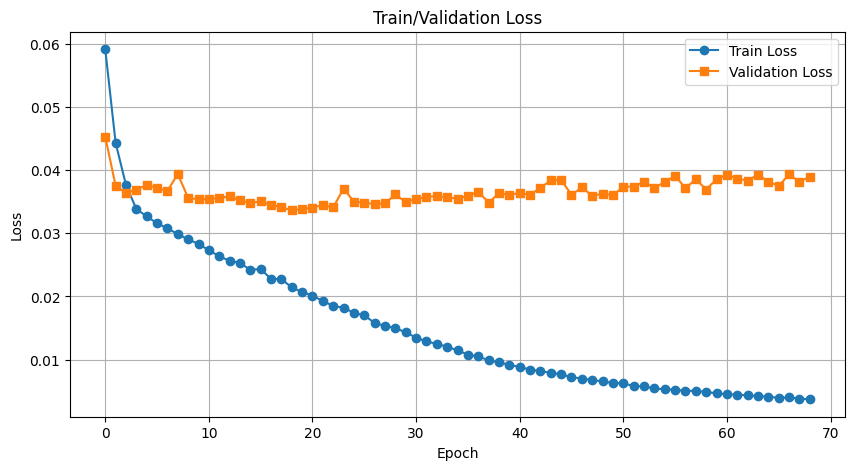

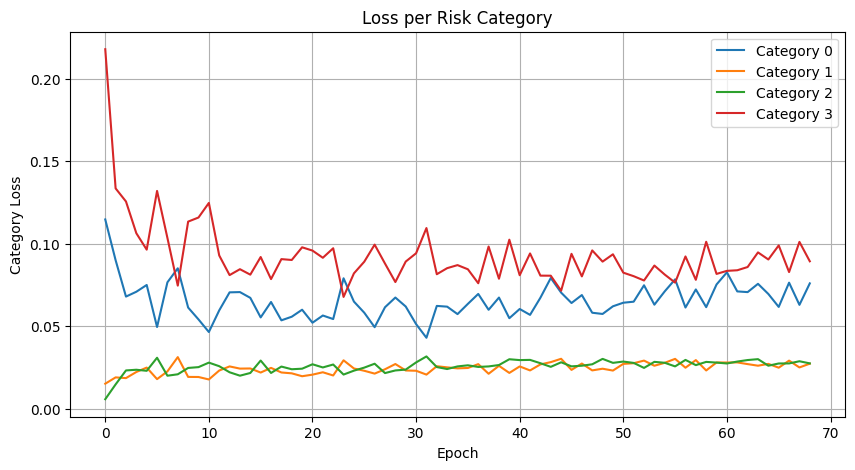

In [23]:
plot_training_history(history)

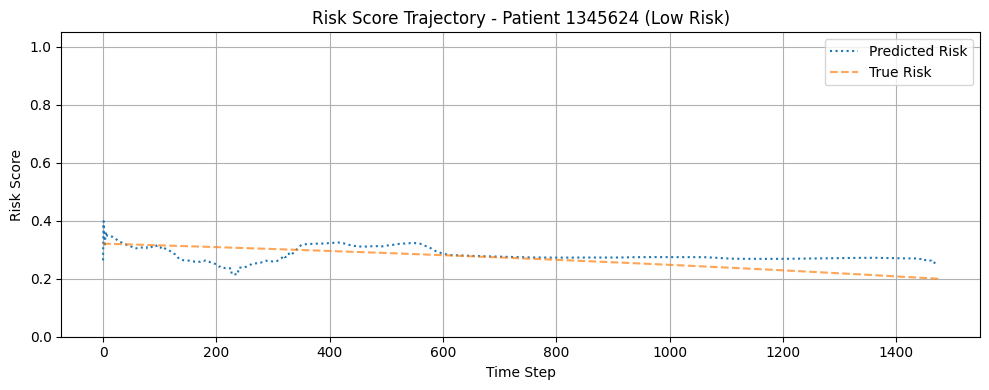

In [25]:
plot_patient_risk_trajectory(model, test_loader, patient_index=32, graph_data=graph_dataset.graph_data, device=device)

In [ ]:
def collect_k_and_category(model, loader, graph_data, device):
    model.eval()
    all_k, all_cat, all_risk = [], [], []

    with torch.no_grad():
        for batch in loader:
            patient_ids, flat_data, ts_data, risk_data, lengths, categories = batch
            flat_data = flat_data.to(device)
            ts_data = ts_data.to(device)
            lengths = lengths.to(device)

            patient_ids = [int(pid) for pid in patient_ids]
            categories = categories.to(device)

            # forward
            risk_scores, _, losses = model(flat_data, graph_data, patient_ids, ts_data, lengths)

            if "k" in losses:
                all_k.extend([k.cpu() for k in losses["k"]])
                all_cat.extend(categories.cpu().tolist())
                all_risk.extend([rs[:l].cpu() for rs, l in zip(risk_scores, lengths)])

    return all_k, all_risk, all_cat


def plot_som_risk_heatmap(k_tensor, risk_tensor, som_grid=(10, 10)):
    # Defensive check and conversion
    if isinstance(k_tensor, list):
        k_tensor = [torch.tensor(k) if not isinstance(k, torch.Tensor) else k for k in k_tensor]
        k_tensor = torch.nn.utils.rnn.pad_sequence(k_tensor, batch_first=True)
    if isinstance(risk_tensor, list):
        risk_tensor = [torch.tensor(r) if not isinstance(r, torch.Tensor) else r for r in risk_tensor]
        risk_tensor = torch.nn.utils.rnn.pad_sequence(risk_tensor, batch_first=True)

    k_tensor = k_tensor.cpu().numpy()
    risk_tensor = risk_tensor.cpu().numpy()

    grid_h, grid_w = som_grid
    risk_sum = np.zeros((grid_h, grid_w))
    risk_count = np.zeros((grid_h, grid_w))

    N, T = risk_tensor.shape
    for i in range(N):
        for t in range(T):
            x, y = k_tensor[i, t]
            x, y = int(x), int(y)
            if 0 <= x < grid_h and 0 <= y < grid_w:
                risk_sum[x, y] += risk_tensor[i, t]
                risk_count[x, y] += 1

    with np.errstate(divide='ignore', invalid='ignore'):
        avg_risk = np.divide(risk_sum, risk_count, out=np.zeros_like(risk_sum), where=risk_count > 0)

    plt.figure(figsize=(6, 6))
    sns.heatmap(avg_risk, cmap='Reds', square=True, cbar_kws={'label': 'Average Risk Score'})
    plt.title("SOM Heatmap of Average Risk Score")
    plt.xlabel("SOM X")
    plt.ylabel("SOM Y")
    plt.tight_layout()
    plt.show()

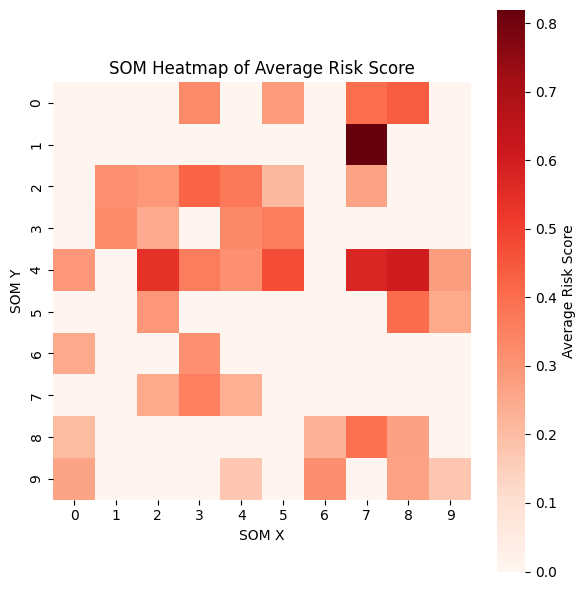

In [27]:
# model.load_state_dict(torch.load('/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth',weights_only=True))

k_tensor, risk_tensor, cat_tensor = collect_k_and_category(model, test_loader, graph_dataset.graph_data, device)
plot_som_risk_heatmap(k_tensor, risk_tensor, som_grid=(10, 10))